In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from catboost import CatBoostClassifier
import xgboost as xgboost
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

import numpy as np
%matplotlib inline

print('LOAD DURATION: ', datetime.now() - start_time) # load time about 30 seconds

LOAD DURATION:  0:00:08.507525


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [3]:
%%time

usecols_skb= ['Cardnum_total_0', 'Cardnum_total_1','Cardnum_total_3','Cardnum_total_7','Cardnum_total_14', 
              'card_state_total_1', 'card_state_total_3', 'card_state_total_7', 'card_state_total_14', 
              'card_zip_total_1','card_zip_total_3', 'card_zip_total_7', 'card_zip_total_14', 'card_zip_total_30', 
              'card_merch_total_1', 'card_merch_total_3', 'card_merch_total_7', 'card_merch_total_14', 
              'card_merch_total_30', 'merch_state_total_1', 'Recnum','Fraud']

usecols_skb_lasso= ['Recnum', 'Fraud', 'card_state_total_3', 'card_zip_total_3', 'card_merch_total_3', 
                    'card_merch_total_7', 'card_merch_total_14']

usecols_stepforward= ['card_zip_total_3','card_state_max_30','card_merch_total_14','card_merch_total_7','card_state_total_30',
             'card_merch_avg_14','merch_state_avg_1','merch_zip_avg_0','Merchnum_avg_0','merch_zip_avg_1',
             'Merchnum_avg_1','card_zip_avg_14','card_merch_avg_7','merch_state_avg_0','Cardnum_total_1',
             'card_merch_total_3','card_merch_avg_3','card_merch_total_0','card_state_total_0','card_zip_total_0',
             'Recnum','Fraud']

usecols_stepforward_lasso= ['Recnum','Fraud', 'card_merch_total_7']

usecols_backward= ['card_merch_total_7', 'card_zip_total_3', 'card_merch_total_14', 'card_zip_total_14', 
                   'card_state_total_7', 'card_state_total_14', 'card_state_total_1', 'card_zip_max_30', 
                   'card_state_total_30', 'card_state_max_14', 'card_zip_max_1', 'merch_state_total_3', 
                   'merch_state_total_1', 'Cardnum_total_3', 'Cardnum_total_7', 'card_state_max_30', 
                   'card_merch_avg_30', 'merch_state_max_1', 'Cardnum_total_1', 'merch_zip_total_0',
                   'Recnum','Fraud']

usecols_backward_lasso= ['Recnum', 'Cardnum_total_7', 'card_state_total_7', 'card_zip_max_1', 
                         'card_zip_max_30', 'merch_zip_total_0','Fraud']
#Variable Created
Day of Week target encoding: dow_risk
State target encoding: state_risk
2
New Entities for Variables:
{'card_state', 'card_zip', 'card_amount', 'merch_amount', 'card_merch', 'merch_zip', 'merch_state'}
7
Days-since: # days since a transaction with that entity has been seen.
Entities are {'Cardnum', 'Merchnum', 'card_state', 'card_zip', 'card_amount', 'merch_amount', 'card_merch', 'merch_zip', 'merch_state'}
9
Frequency: # transactions at that entity over the past n days.
Entities are {'Cardnum', 'Merchnum', 'card_state', 'card_zip', 'card_amount', 'merch_amount', 'card_merch', 'merch_zip', 'merch_state', ('Cardnum','Merchnum'), ('Merchnum','Cardnum'), ('Amount','Cardnum'), ('Amount','Merchnum')}, n is {0, 1, 3, 7, 14, 30}
78
Amount: {Average, Maximum, Median, Total, Actual/average, Actual/maximum, Actual/median, Actual/total} amount at that entity over the past n days.
Entities are {'Cardnum',  'Merchnum', 'card_state', 'card_zip', 'card_merch', 'merch_zip', 'merch_state'}, n is {0, 1, 3, 7, 14, 30}
336
Relative velocity for number: # transactions at that entity seen in a short time window {0 or past 1 day} compared to # transactions at that entity over a longer time window {past 3, 7, 14, 30 days}
Entities are {'Cardnum',  'Merchnum', 'card_state', 'card_zip', 'card_merch', 'merch_zip', 'merch_state'}
72
Relative velocity for amount: Amount of transactions at that {'Cardnum',  'Merchnum'} in a short time window {0 or past 1 day} compared to amount of transactions at that {'Cardnum',  'Merchnum'} over a longer time window {past 3, 7, 14, 30 days}
16
Benford’s Law: Use the two entities Cardnum and Merchnum to calculate the unusualness, U*
2
Total
522




vars_skb = pd.read_csv('vars.csv', usecols = usecols_skb)
vars_skb_lasso = pd.read_csv('vars.csv', usecols = usecols_skb_lasso)
vars_stepforward = pd.read_csv('vars.csv', usecols = usecols_stepforward)
vars_stepforward_lasso = pd.read_csv('vars.csv', usecols = usecols_stepforward_lasso)
vars_backward = pd.read_csv('vars.csv', usecols = usecols_backward)
vars_backward_lasso = pd.read_csv('vars.csv', usecols = usecols_backward_lasso)


CPU times: user 14.6 s, sys: 1.05 s, total: 15.7 s
Wall time: 16.7 s


In [105]:
vars = vars_backward
vars.head(10)

,Recnum,Fraud,Cardnum_total_0,Cardnum_total_1,Cardnum_total_3,Cardnum_total_7,Cardnum_total_14,card_state_total_1,card_state_total_3,card_state_total_7,...,card_zip_total_3,card_zip_total_7,card_zip_total_14,card_zip_total_30,card_merch_total_1,card_merch_total_3,card_merch_total_7,card_merch_total_14,card_merch_total_30,merch_state_total_1
0,1,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,7.24
4,5,0,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,...,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,10.86
5,6,0,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67,...,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67,14.53
6,7,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,18.15
7,8,0,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,...,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32
8,9,0,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,...,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11
9,10,0,10.86,10.86,10.86,10.86,10.86,10.86,10.86,10.86,...,10.86,10.86,10.86,10.86,10.86,10.86,10.86,10.86,10.86,21.77


In [106]:
# use this to cap variables. For some problems it helps
Clip = 10

In [107]:
vars['Fraud'].sum()

1059

In [108]:
vars.shape

(96397, 22)

In [109]:
vars.describe()

,Recnum,Fraud,Cardnum_total_0,Cardnum_total_1,Cardnum_total_3,Cardnum_total_7,Cardnum_total_14,card_state_total_1,card_state_total_3,card_state_total_7,...,card_zip_total_3,card_zip_total_7,card_zip_total_14,card_zip_total_30,card_merch_total_1,card_merch_total_3,card_merch_total_7,card_merch_total_14,card_merch_total_30,merch_state_total_1
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,...,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,48365.481820,0.010986,741.645565,1110.045587,1512.932952,2384.036098,3768.183808,658.801075,737.869736,902.263993,...,641.696503,710.502552,805.398964,989.355309,599.824086,631.592947,691.248912,773.478689,930.102629,1124.903699
std,27945.003883,0.104236,3431.446131,5669.434127,6115.505329,7158.500841,9421.917379,4054.415369,4120.864187,4246.471258,...,4066.606386,4112.186652,4186.589280,4345.734883,4020.452418,4063.110709,4104.238743,4170.834510,4306.518987,4362.985595
min,1.000000,0.000000,0.010000,0.010000,0.010000,0.140000,0.140000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,24154.000000,0.000000,60.000000,90.000000,140.000000,292.400000,556.340000,55.440000,65.480000,87.500000,...,58.290000,70.400000,84.900000,105.240000,50.000000,55.250000,65.710000,77.350000,94.290000,118.000000
50%,48365.000000,0.000000,220.000000,339.160000,518.610000,986.140000,1723.640000,189.980000,216.500000,280.000000,...,185.520000,215.000000,256.450000,321.000000,168.000000,179.950000,203.470000,238.780000,291.750000,395.560000
75%,72578.000000,0.000000,685.650000,1043.110000,1550.000000,2566.000000,4093.250000,577.200000,659.000000,837.440000,...,556.430000,621.980000,716.560000,902.190000,512.550000,545.010000,600.000000,681.930000,834.640000,1135.840000
max,96753.000000,1.000000,218301.830000,307468.060000,310843.060000,312616.060000,313995.060000,306633.410000,306633.410000,306633.410000,...,306633.410000,306633.410000,306633.410000,306633.410000,306633.410000,306633.410000,306633.410000,306633.410000,306633.410000,306633.410000


In [110]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [111]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,Cardnum_total_0,Cardnum_total_1,Cardnum_total_3,Cardnum_total_7,Cardnum_total_14,card_state_total_1,card_state_total_3,card_state_total_7,card_state_total_14,card_zip_total_1,card_zip_total_3,card_zip_total_7,card_zip_total_14,card_zip_total_30,card_merch_total_1,card_merch_total_3,card_merch_total_7,card_merch_total_14,card_merch_total_30,merch_state_total_1
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,741.645565,1110.045587,1512.932952,2384.036098,3768.183808,658.801075,737.869736,902.263993,1150.539713,605.584869,641.696503,710.502552,805.398964,989.355309,599.824086,631.592947,691.248912,773.478689,930.102629,1124.903699
std,3431.446131,5669.434127,6115.505329,7158.500841,9421.917379,4054.415369,4120.864187,4246.471258,4507.600609,4022.504312,4066.606386,4112.186652,4186.589280,4345.734883,4020.452418,4063.110709,4104.238743,4170.834510,4306.518987,4362.985595
min,0.010000,0.010000,0.010000,0.140000,0.140000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,60.000000,90.000000,140.000000,292.400000,556.340000,55.440000,65.480000,87.500000,113.560000,51.000000,58.290000,70.400000,84.900000,105.240000,50.000000,55.250000,65.710000,77.350000,94.290000,118.000000
50%,220.000000,339.160000,518.610000,986.140000,1723.640000,189.980000,216.500000,280.000000,365.270000,171.600000,185.520000,215.000000,256.450000,321.000000,168.000000,179.950000,203.470000,238.780000,291.750000,395.560000
75%,685.650000,1043.110000,1550.000000,2566.000000,4093.250000,577.200000,659.000000,837.440000,1091.360000,520.000000,556.430000,621.980000,716.560000,902.190000,512.550000,545.010000,600.000000,681.930000,834.640000,1135.840000
max,218301.830000,307468.060000,310843.060000,312616.060000,313995.060000,306633.410000,306633.410000,306633.410000,306633.410000,306633.410000,306633.410000,306633.410000,306633.410000,306633.410000,306633.410000,306633.410000,306633.410000,306633.410000,306633.410000,306633.410000


In [112]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [113]:
# push in any outlier values
cols = X.columns
X.loc[:,cols] = X[cols].clip(upper=Clip)
X.loc[:,cols] = X[cols].clip(lower=-1*Clip)

X.describe()

,Cardnum_total_0,Cardnum_total_1,Cardnum_total_3,Cardnum_total_7,Cardnum_total_14,card_state_total_1,card_state_total_3,card_state_total_7,card_state_total_14,card_zip_total_1,card_zip_total_3,card_zip_total_7,card_zip_total_14,card_zip_total_30,card_merch_total_1,card_merch_total_3,card_merch_total_7,card_merch_total_14,card_merch_total_30,merch_state_total_1
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,-0.015303,-0.016958,-0.016033,-0.014465,-0.013169,-0.012398,-0.012330,-0.012043,-0.011538,-0.012554,-0.012608,-0.012515,-0.012247,-0.011520,-0.012565,-0.012627,-0.012558,-0.012329,-0.011710,-0.011512
std,0.563192,0.541879,0.603512,0.694553,0.771249,0.449155,0.473886,0.517611,0.586084,0.433062,0.448165,0.466324,0.496054,0.553797,0.431967,0.446373,0.462533,0.489352,0.540337,0.558051
min,-0.216129,-0.195793,-0.247391,-0.333016,-0.399923,-0.162487,-0.179055,-0.212471,-0.255242,-0.150547,-0.157794,-0.172777,-0.192374,-0.227659,-0.149191,-0.155443,-0.168421,-0.185447,-0.215973,-0.257827
25%,-0.198647,-0.179920,-0.224500,-0.292189,-0.340891,-0.148816,-0.163167,-0.191868,-0.230051,-0.137871,-0.143463,-0.155660,-0.172097,-0.203444,-0.136757,-0.141848,-0.152413,-0.166904,-0.194081,-0.230783
50%,-0.152019,-0.135972,-0.162590,-0.195278,-0.216999,-0.115632,-0.126520,-0.146537,-0.174210,-0.107889,-0.112176,-0.120496,-0.131121,-0.153796,-0.107407,-0.111157,-0.118848,-0.128199,-0.148229,-0.167166
75%,-0.016318,-0.011806,0.006061,0.025419,0.034501,-0.020126,-0.019139,-0.015265,-0.013129,-0.021277,-0.020967,-0.021527,-0.021220,-0.020058,-0.021708,-0.021310,-0.022233,-0.021950,-0.022167,0.002507
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [114]:
# separate data into modeling (traintest) and out of time
oot_recnum=84300
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

In [115]:
niter = 0
nitermax = 5
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

# Regularization

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt 

from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error


In [16]:
alphas = 10**np.linspace(10,-2,100)*0.5

In [17]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [18]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(100, 5)

Text(0.5, 1.0, 'Ridge')

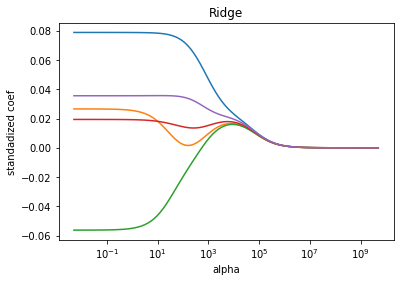

In [19]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha') 
plt.ylabel('standadized coef') 
plt.title('Ridge')

In [20]:
lasso = Lasso(max_iter=10000) 
coefs = [] 
for a in alphas: 
    lasso.set_params(alpha=a) 
    lasso.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(lasso.coef_) 
# print('Shape:',np.shape(coefs)
print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

Selected Features: ['Recnum', 'card_merch_total_3']


No handles with labels found to put in legend.


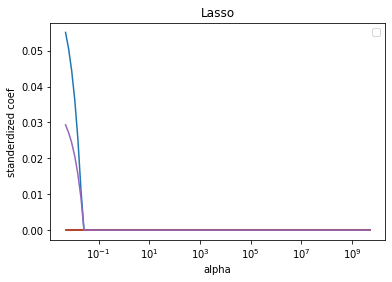

In [21]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('standerdized coef') 
plt.title('Lasso')
plt.legend()

# Logistic Regression

In [22]:
# param_grid = {
#     'num_leaves': [31, 127],
#     'reg_alpha': [0.1, 0.5],
#     'min_data_in_leaf': [30, 50, 100, 300, 400],
#     'lambda_l1': [0, 1, 1.5],
#     'lambda_l2': [0, 1]
#     }

# bt = lgb.LGBMClassifier()
# grid_search = GridSearchCV(bt, param_grid,cv=5,
#                           scoring='neg_mean_squared_error')
 
# grid_search.fit(trn.iloc[:, 1:5],trn.iloc[:, 5])
# grid_search.best_params_

In [23]:
%%time
# Logistic regression

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression()
#     penalty='l1', C=1, solver='saga'
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0 0.6367924528301887 0.6147540983606558 0.33519553072625696


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1 0.6489533011272142 0.5907335907335908 0.3743016759776536


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2 0.6272 0.6431372549019608 0.35195530726256985


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3 0.6333333333333333 0.636 0.30726256983240224


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4 0.6345177664974619 0.6055363321799307 0.36312849162011174


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5 0.6272577996715928 0.6494464944649446 0.30726256983240224


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6 0.6432078559738135 0.6171003717472119 0.31843575418994413


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7 0.6395348837209303 0.6187050359712231 0.3240223463687151
8 0.6111111111111112 0.6529850746268657 0.4134078212290503


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9 0.6103059581320451 0.6640926640926641 0.329608938547486
trn    0.631221
tst    0.629249
oot    0.342458
dtype: float64
CPU times: user 2.97 s, sys: 198 ms, total: 3.17 s
Wall time: 2.51 s


# Decision Tree

In [24]:
%%time
# Single DT

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier()
#     criterion='gini', splitter='best', max_depth=20, min_samples_split=300,
#                             min_samples_leaf=60, max_features=None  
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

0 1.0 0.42424242424242425 0.2122905027932961
1 1.0 0.3957597173144876 0.2346368715083799
2 1.0 0.38223938223938225 0.19553072625698323
3 1.0 0.3192307692307692 0.2011173184357542
4 1.0 0.36531365313653136 0.24581005586592178
5 1.0 0.3345323741007194 0.2011173184357542
6 1.0 0.37777777777777777 0.19553072625698323
7 1.0 0.40344827586206894 0.21787709497206703
8 1.0 0.37410071942446044 0.2346368715083799
9 1.0 0.38661710037174724 0.2122905027932961
trn    1.000000
tst    0.376326
oot    0.215084
dtype: float64
CPU times: user 7.48 s, sys: 205 ms, total: 7.69 s
Wall time: 8.38 s


In [123]:
%%time
# Single DT

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(
        criterion='gini', 
        splitter='best', 
        max_depth=8, 
#         min_samples_leaf=60, 
        min_samples_split=100,
#         max_features=None
    )
#     
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

0 0.7429519071310116 0.631768953068592 0.39106145251396646
1 0.7194127243066885 0.7265917602996255 0.4022346368715084
2 0.7018633540372671 0.6694915254237288 0.5027932960893855
3 0.7272727272727273 0.6284584980237155 0.4245810055865922
4 0.7243066884176182 0.6779026217228464 0.4022346368715084
trn    0.723161
tst    0.666843
oot    0.424581
dtype: float64
CPU times: user 6.5 s, sys: 139 ms, total: 6.64 s
Wall time: 5.43 s


# Random Forest

In [23]:

param_grid = {
    'max_depth': np.arange(1,20),
    'min_sample_split': np.arange(5,50,5),
    'min_samples_leaf': np.arange(10,100,10),
    'n_estimators': np.arange(30,200,10)
    }

rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid,cv=5)
 
grid_search.fit(X,Y_save)
grid_search.best_params_


ValueError: Invalid parameter min_sample_split for estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=1, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [34]:
%%time
# RF

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
    model = RandomForestClassifier(
        criterion='gini',
        max_depth=8,
        min_samples_leaf=60, 
        min_samples_split=10,
        n_estimators=56)
    
    #keep tree simple but # of tree increase
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])

print(FDR3.mean())

0 0.7672552166934189 0.7003891050583657 0.5083798882681564
1 0.7619047619047619 0.7232472324723247 0.5083798882681564
2 0.7622047244094489 0.7428571428571429 0.5307262569832403
3 0.7527910685805422 0.7391304347826086 0.5083798882681564
4 0.768 0.7176470588235294 0.5083798882681564
trn    0.762431
tst    0.724654
oot    0.512849
dtype: float64
CPU times: user 45 s, sys: 654 ms, total: 45.7 s
Wall time: 47.7 s


In [40]:
%%time
# RF

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
    model = RandomForestClassifier(
        criterion='gini',
        max_depth=7,
        min_samples_leaf=60, 
        min_samples_split=10,
        n_estimators=50)
    
    #keep tree simple but # of tree increase
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])

print(FDR3.mean())

0 0.7651757188498403 0.6889763779527559 0.4972067039106145
1 0.7432216905901117 0.7628458498023716 0.48044692737430167
2 0.7654941373534339 0.7102473498233216 0.5195530726256983
3 0.7409733124018838 0.7654320987654321 0.4860335195530726
4 0.750788643533123 0.7357723577235772 0.48044692737430167
trn    0.753131
tst    0.732655
oot    0.492737
dtype: float64
CPU times: user 38.1 s, sys: 636 ms, total: 38.8 s
Wall time: 41.4 s


In [25]:
%%time
# RF

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
    model = RandomForestClassifier(
        criterion='gini',
        max_depth=8,
        min_samples_leaf=60, 
        min_samples_split=10,
        n_estimators=65)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])

print(FDR3.mean())

0 0.7671009771986971 0.7218045112781954 0.553072625698324
1 0.7544426494345718 0.7586206896551724 0.547486033519553
2 0.7634228187919463 0.7253521126760564 0.4860335195530726
3 0.7431340872374798 0.7854406130268199 0.5865921787709497
4 0.7423014586709886 0.7718631178707225 0.5307262569832403
trn    0.754080
tst    0.752616
oot    0.540782
dtype: float64
CPU times: user 50.8 s, sys: 634 ms, total: 51.4 s
Wall time: 50.9 s


# Boosted Tree

In [91]:
%%time
# BT

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(
        learning_rate=0.001, 
        max_depth=10, 
        num_leaves=100,
        subsample=0.8,
        boosting_type='gbdt'

    
    )
#     

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

0 0.860062893081761 0.7049180327868853 0.4692737430167598
1 0.8905472636815921 0.7472924187725631 0.547486033519553
2 0.8898026315789473 0.7426470588235294 0.5139664804469274
3 0.8536585365853658 0.7320754716981132 0.43575418994413406
4 0.8661290322580645 0.7230769230769231 0.48044692737430167
trn    0.872040
tst    0.730002
oot    0.489385
dtype: float64
CPU times: user 28.4 s, sys: 1.06 s, total: 29.5 s
Wall time: 9.49 s


In [82]:
%%time
# BT

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(
        learning_rate=0.01, 
        max_depth=5, 
        num_leaves=15, 
        n_estimators=161)
#     

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

0 0.819935691318328 0.7596899224806202 0.5195530726256983
1 0.8089368258859785 0.7272727272727273 0.4581005586592179
2 0.8391376451077943 0.7256317689530686 0.4692737430167598
3 0.8201320132013201 0.7627737226277372 0.4581005586592179
4 0.8210702341137124 0.7163120567375887 0.44692737430167595
trn    0.821842
tst    0.738336
oot    0.470391
dtype: float64
CPU times: user 20.7 s, sys: 922 ms, total: 21.7 s
Wall time: 6.27 s


# Gradient Boosting Tree

In [38]:
%%time
# GBT

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = GradientBoostingClassifier(
        learning_rate=0.01,
        max_depth= 8,
#         min_samples_leaf= 60,
#         min_samples_split= 10,
#         n_estimators=50
    )


    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

0 0.8025682182985554 0.7509727626459144 0.39664804469273746
1 0.8118971061093248 0.7093023255813954 0.4692737430167598
2 0.7936772046589018 0.7168458781362007 0.4860335195530726
3 0.7774244833068362 0.7171314741035857 0.5083798882681564
4 0.7891268533772653 0.6776556776556777 0.37988826815642457
trn    0.794939
tst    0.714382
oot    0.448045
dtype: float64
CPU times: user 4min 8s, sys: 1.06 s, total: 4min 9s
Wall time: 4min 9s


In [43]:
%%time
# GBT

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = GradientBoostingClassifier(
        learning_rate=0.01,
        max_depth= 5,
#         min_samples_leaf= 50,
#         min_samples_split= 10,
        n_estimators=150
    )


    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

0 0.7401960784313726 0.7052238805970149 0.43575418994413406
1 0.7645161290322581 0.7346153846153847 0.441340782122905
2 0.7483552631578947 0.7058823529411765 0.43575418994413406
3 0.7405660377358491 0.7049180327868853 0.36312849162011174
4 0.7336448598130841 0.7016806722689075 0.4581005586592179
trn    0.745456
tst    0.710464
oot    0.426816
dtype: float64
CPU times: user 3min 12s, sys: 2.75 s, total: 3min 14s
Wall time: 3min 42s


# NN

In [28]:
%%time
# NN

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier()
#     hidden_layer_sizes=(100,),activation='relu',solver='adam',alpha=0.001,learning_rate='adaptive',
#     learning_rate_init=0.001,max_iter=200
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

0 0.631578947368421 0.6580882352941176 0.3687150837988827
1 0.6324503311258278 0.6630434782608695 0.3240223463687151
2 0.6403225806451613 0.6384615384615384 0.3743016759776536
3 0.6276422764227643 0.6641509433962264 0.3854748603351955
4 0.6327503974562798 0.6533864541832669 0.3687150837988827
5 0.6411960132890365 0.6438848920863309 0.3687150837988827
6 0.6423948220064725 0.6221374045801527 0.3743016759776536
7 0.6502463054187192 0.6162361623616236 0.3463687150837989
8 0.64375 0.6375 0.329608938547486
9 0.6283048211508554 0.6582278481012658 0.441340782122905
trn    0.637064
tst    0.645512
oot    0.368156
dtype: float64
CPU times: user 1min 49s, sys: 3.49 s, total: 1min 52s
Wall time: 1min 25s


In [53]:
%%time
# NN

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(
        hidden_layer_sizes=(50,),
#         max_iter=200,
#         activation='relu',
#         solver='adam',
        alpha=0.1,
#         learning_rate_init=0.001,
        learning_rate='adaptive'
        )
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

0 0.7721311475409836 0.7074074074074074 0.5810055865921788
1 0.7869127516778524 0.6866197183098591 0.5977653631284916
2 0.7644151565074135 0.7472527472527473 0.5921787709497207
3 0.7608346709470305 0.7315175097276264 0.5977653631284916
4 0.7661691542288557 0.740072202166065 0.6033519553072626
trn    0.770093
tst    0.722574
oot    0.594413
dtype: float64
CPU times: user 2min 10s, sys: 3.79 s, total: 2min 14s
Wall time: 1min 17s


In [104]:
%%time
# NN

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(
        hidden_layer_sizes=(60,30,15,),
#         max_iter=200,
        activation='relu',
#         solver='adam',
        alpha=0.01,
#         learning_rate_init=0.001,
        learning_rate='adaptive'
        )
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

0 0.8484848484848485 0.8023715415019763 0.5418994413407822
1 0.8512 0.7803921568627451 0.5642458100558659
2 0.853225806451613 0.7807692307692308 0.5363128491620112
3 0.8503184713375797 0.7936507936507936 0.6424581005586593
4 0.8827361563517915 0.7781954887218046 0.5418994413407822
trn    0.857193
tst    0.787076
oot    0.565363
dtype: float64
CPU times: user 9min 30s, sys: 11.5 s, total: 9min 41s
Wall time: 5min 33s


In [62]:
%%time
# NN

for niter in range(10):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(
        hidden_layer_sizes=(60),
#         max_iter=200,
#         activation='relu',
#         solver='adam',
        alpha=0.01,
#         learning_rate_init=0.001,
        learning_rate='adaptive'
        )
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

0 0.7680412371134021 0.7449664429530202 0.6145251396648045
1 0.7653910149750416 0.7132616487455197 0.5642458100558659
2 0.7691082802547771 0.6984126984126984 0.5642458100558659
3 0.7732463295269169 0.7191011235955056 0.6089385474860335
4 0.7644230769230769 0.73046875 0.6368715083798883
5 0.7648 0.7294117647058823 0.5977653631284916
6 0.7557755775577558 0.7627737226277372 0.6089385474860335
7 0.7782874617737003 0.7035398230088495 0.6368715083798883
8 0.7611202635914333 0.7435897435897436 0.6089385474860335
9 0.7562604340567612 0.7224199288256228 0.6033519553072626
trn    0.765645
tst    0.726795
oot    0.604469
dtype: float64
CPU times: user 4min 28s, sys: 6.8 s, total: 4min 35s
Wall time: 2min 31s


In [59]:
%%time
# NN

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(
        hidden_layer_sizes=(65),
#         max_iter=200,
#         activation='relu',
#         solver='adam',
        alpha=0.01,
#         learning_rate_init=0.001,
        learning_rate='adaptive'
        )
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

0 0.7797716150081566 0.7078651685393258 0.5754189944134078
1 0.7540453074433657 0.7557251908396947 0.5921787709497207
2 0.7609427609427609 0.7342657342657343 0.5865921787709497
3 0.7541528239202658 0.7517985611510791 0.5865921787709497
4 0.7711038961038961 0.7272727272727273 0.6368715083798883
trn    0.763438
tst    0.732498
oot    0.596648
dtype: float64
CPU times: user 2min 40s, sys: 5.29 s, total: 2min 45s
Wall time: 1min 44s


# CatBoost

In [75]:
%%time
# CatBoost

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(
            iterations=100,
#             learning_rate=0.03,
#             l2_leaf_reg=5
    
    )
#     

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

Learning rate set to 0.485422
0:	learn: 0.0903270	total: 17.9ms	remaining: 1.77s
1:	learn: 0.0411562	total: 34.4ms	remaining: 1.68s
2:	learn: 0.0334225	total: 45.7ms	remaining: 1.48s
3:	learn: 0.0294381	total: 59.6ms	remaining: 1.43s
4:	learn: 0.0277436	total: 73.2ms	remaining: 1.39s
5:	learn: 0.0269169	total: 85.9ms	remaining: 1.35s
6:	learn: 0.0264037	total: 99ms	remaining: 1.31s
7:	learn: 0.0256345	total: 113ms	remaining: 1.29s
8:	learn: 0.0250722	total: 130ms	remaining: 1.32s
9:	learn: 0.0245042	total: 146ms	remaining: 1.31s
10:	learn: 0.0242957	total: 163ms	remaining: 1.32s
11:	learn: 0.0239468	total: 181ms	remaining: 1.32s
12:	learn: 0.0236865	total: 197ms	remaining: 1.32s
13:	learn: 0.0234565	total: 235ms	remaining: 1.44s
14:	learn: 0.0230986	total: 254ms	remaining: 1.44s
15:	learn: 0.0228143	total: 271ms	remaining: 1.42s
16:	learn: 0.0225277	total: 289ms	remaining: 1.41s
17:	learn: 0.0221383	total: 308ms	remaining: 1.4s
18:	learn: 0.0219070	total: 324ms	remaining: 1.38s
19:	lea

64:	learn: 0.0148892	total: 1.53s	remaining: 822ms
65:	learn: 0.0148306	total: 1.56s	remaining: 802ms
66:	learn: 0.0147261	total: 1.58s	remaining: 776ms
67:	learn: 0.0146149	total: 1.6s	remaining: 751ms
68:	learn: 0.0144795	total: 1.62s	remaining: 727ms
69:	learn: 0.0144291	total: 1.64s	remaining: 702ms
70:	learn: 0.0143365	total: 1.66s	remaining: 677ms
71:	learn: 0.0142473	total: 1.67s	remaining: 651ms
72:	learn: 0.0142008	total: 1.69s	remaining: 624ms
73:	learn: 0.0141567	total: 1.7s	remaining: 599ms
74:	learn: 0.0141372	total: 1.73s	remaining: 576ms
75:	learn: 0.0140220	total: 1.75s	remaining: 553ms
76:	learn: 0.0139798	total: 1.78s	remaining: 532ms
77:	learn: 0.0139566	total: 1.8s	remaining: 508ms
78:	learn: 0.0136721	total: 1.82s	remaining: 484ms
79:	learn: 0.0135549	total: 1.84s	remaining: 460ms
80:	learn: 0.0134225	total: 1.88s	remaining: 440ms
81:	learn: 0.0133879	total: 1.9s	remaining: 418ms
82:	learn: 0.0132761	total: 1.94s	remaining: 397ms
83:	learn: 0.0132206	total: 1.97s	r

23:	learn: 0.0200263	total: 521ms	remaining: 1.65s
24:	learn: 0.0198533	total: 541ms	remaining: 1.62s
25:	learn: 0.0195906	total: 567ms	remaining: 1.61s
26:	learn: 0.0193535	total: 590ms	remaining: 1.6s
27:	learn: 0.0191668	total: 608ms	remaining: 1.56s
28:	learn: 0.0190329	total: 623ms	remaining: 1.52s
29:	learn: 0.0189421	total: 641ms	remaining: 1.49s
30:	learn: 0.0186161	total: 662ms	remaining: 1.47s
31:	learn: 0.0182174	total: 680ms	remaining: 1.45s
32:	learn: 0.0179313	total: 715ms	remaining: 1.45s
33:	learn: 0.0177401	total: 753ms	remaining: 1.46s
34:	learn: 0.0176199	total: 783ms	remaining: 1.45s
35:	learn: 0.0175509	total: 808ms	remaining: 1.44s
36:	learn: 0.0173934	total: 829ms	remaining: 1.41s
37:	learn: 0.0172743	total: 851ms	remaining: 1.39s
38:	learn: 0.0171354	total: 883ms	remaining: 1.38s
39:	learn: 0.0170017	total: 910ms	remaining: 1.36s
40:	learn: 0.0169494	total: 926ms	remaining: 1.33s
41:	learn: 0.0168712	total: 944ms	remaining: 1.3s
42:	learn: 0.0166507	total: 977ms

86:	learn: 0.0126604	total: 3.15s	remaining: 472ms
87:	learn: 0.0126290	total: 3.19s	remaining: 435ms
88:	learn: 0.0125561	total: 3.21s	remaining: 397ms
89:	learn: 0.0125163	total: 3.22s	remaining: 358ms
90:	learn: 0.0124567	total: 3.24s	remaining: 321ms
91:	learn: 0.0124359	total: 3.26s	remaining: 283ms
92:	learn: 0.0123771	total: 3.27s	remaining: 246ms
93:	learn: 0.0122860	total: 3.29s	remaining: 210ms
94:	learn: 0.0121490	total: 3.31s	remaining: 174ms
95:	learn: 0.0121164	total: 3.32s	remaining: 138ms
96:	learn: 0.0120579	total: 3.34s	remaining: 103ms
97:	learn: 0.0120123	total: 3.35s	remaining: 68.4ms
98:	learn: 0.0119606	total: 3.37s	remaining: 34ms
99:	learn: 0.0119046	total: 3.39s	remaining: 0us
4 0.9223140495867769 0.7563636363636363 0.547486033519553
trn    0.915846
tst    0.763613
oot    0.518436
dtype: float64
CPU times: user 20.8 s, sys: 1.84 s, total: 22.6 s
Wall time: 13.8 s


# XGBoost

In [118]:
%%time
# XGBoost

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = XGBClassifier(
        booster='gbtree',
        max_depth=5, 
        min_child_weight=75,
        sub_sample=75,
        gamma=0.01, 
    )
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

[22:07:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:07:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0 0.8041074249605056 0.7327935222672065 0.547486033519553
[22:07:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some 

In [161]:
%%time
# XGBoost

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = XGBClassifier(
        booster='gbtree',
        max_depth=8, 
        min_child_weight=80,
        sub_sample=40,
        gamma=0.03, 
    )
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:33:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0 0.7852564102564102 0.7734375 0.5586592178770949
[15:33:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some paramete

# KNN

In [167]:
%%time
# KNN

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = KNeighborsClassifier(
        n_neighbors=35, 
        leaf_size=50)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

0 0.8054662379421221 0.7635658914728682 0.5418994413407822
1 0.8132045088566827 0.7760617760617761 0.5642458100558659
2 0.8018867924528302 0.7745901639344263 0.5698324022346368
3 0.8186195826645265 0.7237354085603113 0.5418994413407822
4 0.8096774193548387 0.7807692307692308 0.547486033519553
trn    0.809771
tst    0.763744
oot    0.553073
dtype: float64
CPU times: user 3min 36s, sys: 2.66 s, total: 3min 39s
Wall time: 3min 57s


In [15]:
%%time
# KNN

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = KNeighborsClassifier(
        n_neighbors=29, 
        leaf_size=50)
    

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

0 0.8325123152709359 0.7490774907749077 0.5307262569832403
1 0.8150572831423896 0.7620817843866171 0.5977653631284916
2 0.8322475570032574 0.7255639097744361 0.5921787709497207
3 0.8141891891891891 0.7395833333333334 0.5307262569832403
4 0.819376026272578 0.7343173431734318 0.547486033519553
trn    0.822676
tst    0.742125
oot    0.559777
dtype: float64
CPU times: user 3min 28s, sys: 3.42 s, total: 3min 31s
Wall time: 4min 32s


# SVM

In [77]:
%%time
# SVM

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = svm.SVC(
#         C=0.1, 
#         gamma=100,
        kernel='linear',
        probability=True)
  

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

0 0.6331058020477816 0.6122448979591837 0.30726256983240224
1 0.6293245469522241 0.6593406593406593 0.33519553072625696
2 0.6276083467094703 0.6303501945525292 0.31843575418994413
3 0.6480891719745223 0.5873015873015873 0.30726256983240224
4 0.6434494195688225 0.6137184115523465 0.3240223463687151
trn    0.636315
tst    0.620591
oot    0.318436
dtype: float64
CPU times: user 5min 15s, sys: 9.42 s, total: 5min 25s
Wall time: 5min 49s


In [78]:
%%time
# SVM

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = svm.SVC(
#         C=0.1, 
#         gamma=100,
        kernel='poly',
        probability=True)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0 0.7329093799682035 0.7211155378486056 0.6089385474860335


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


1 0.7121212121212122 0.7552447552447552 0.5195530726256983


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


2 0.7553719008264462 0.6836363636363636 0.4972067039106145


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


3 0.753125 0.6875 0.4860335195530726


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


4 0.7586776859504132 0.6981818181818182 0.5139664804469274
trn    0.742441
tst    0.709136
oot    0.525140
dtype: float64
CPU times: user 26min 21s, sys: 26.9 s, total: 26min 48s
Wall time: 31min 12s


In [80]:
%%time
# SVM

for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = svm.SVC(
        C=10, 
#         gamma=100,
        kernel='poly',
        probability=True)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    
print(FDR3.mean())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0 0.7475728155339806 0.7061068702290076 0.5027932960893855


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


1 0.7579831932773109 0.7052631578947368 0.441340782122905


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


2 0.751937984496124 0.7148936170212766 0.5307262569832403


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


3 0.7635782747603834 0.6850393700787402 0.5195530726256983


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


4 0.7435483870967742 0.7 0.5363128491620112
trn    0.752924
tst    0.702261
oot    0.506145
dtype: float64
CPU times: user 1h 3min 45s, sys: 1min 11s, total: 1h 4min 56s
Wall time: 1h 17min 56s


# Comparison plot

In [2]:
df = pd.read_excel('Modeling output.xlsx')

In [3]:
df.head()

,Model,Train,Test,OOT
0,Logistic Regression,0.632543,0.622926,0.363128
1,Logistic Regression,0.632454,0.623528,0.363128
2,Logistic Regression,0.631134,0.625092,0.363128
3,Logistic Regression,0.628194,0.634535,0.363128
4,Decision Tree,1.000000,0.525071,0.284358


In [9]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Train','Test','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()


,Model,Type,Value
0,Logistic Regression,Train,0.632543
1,Logistic Regression,Train,0.632454
2,Logistic Regression,Train,0.631134
3,Logistic Regression,Train,0.628194
4,Decision Tree,Train,1.000000


In [10]:
df_compare = df_unpivot[(df_unpivot['Type']=='Train') | (df_unpivot['Type']=='Test')]
df_compare.head()

,Model,Type,Value
0,Logistic Regression,Train,0.632543
1,Logistic Regression,Train,0.632454
2,Logistic Regression,Train,0.631134
3,Logistic Regression,Train,0.628194
4,Decision Tree,Train,1.000000


In [4]:
output = df.groupby('Model').agg({'Train':['mean','std'],'Test':['mean','std'],'OOT':['mean','std']})
output

Train                Test                 OOT  \
                            mean       std      mean       std      mean   
Model                                                                      
Boosted Tree            0.940775  0.054730  0.850075  0.022342  0.543700   
CatBoost                0.895143  0.043272  0.774031  0.012913  0.535531   
Decision Tree           0.756899  0.090211  0.672854  0.054262  0.417375   
Gradient Boosting Tree  0.894623  0.070288  0.827655  0.041695  0.545140   
KNN                     0.843146  0.056663  0.755858  0.009286  0.542346   
Logistic Regression     0.631081  0.002030  0.626520  0.005421  0.363128   
Neural Network          0.783998  0.027108  0.748745  0.016655  0.578317   
Random Forest           0.916529  0.068448  0.826754  0.025539  0.578324   
SVM                     0.673673  0.212638  0.642178  0.191341  0.416015   
XGBoost                 0.885568  0.060092  0.833094  0.040486  0.549441   

                                  
                             std  
Model                             
Boosted Tree            0.034278  
CatBoost                0.026639  
Decision Tree           0.053134  
Gradient Boosting Tree  0.030774  
KNN                     0.037423  
Logistic Regression     0.000000  
Neural Network          0.018382  
Random Forest           0.018683  
SVM                     0.151211  
XGBoost                 0.018674

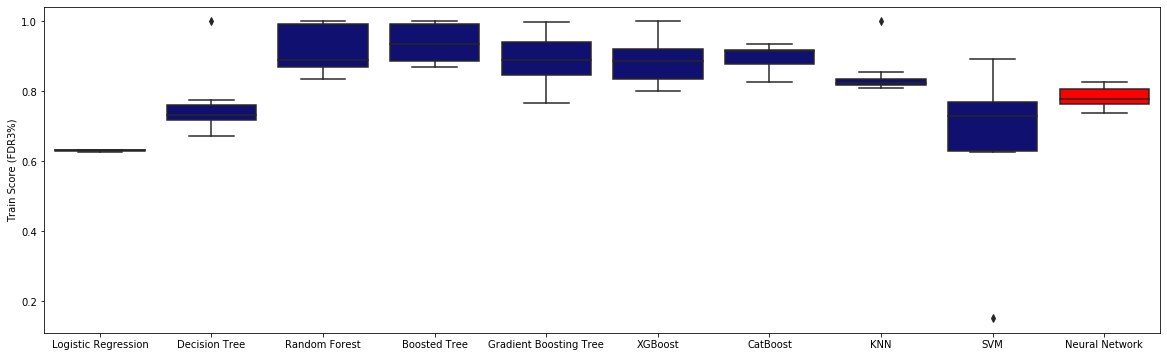

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
ax = sns.boxplot(x='Model',y='Train', data=df, color='navy')

# Select which box you want to change    
mybox = ax.artists[9]

# Change the appearance of that box
mybox.set_facecolor('red')
# mybox.set_edgecolor('black')
# mybox.set_linewidth(3)
plt.xlabel('')
plt.ylabel('Train Score (FDR3%)')
plt.show()

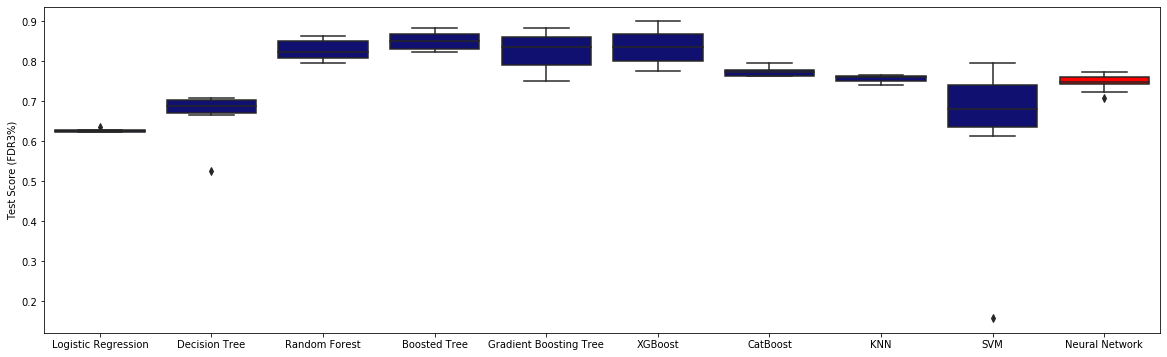

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
ax = sns.boxplot(x='Model',y='Test', data=df, color='navy')

# Select which box you want to change    
mybox = ax.artists[9]

# Change the appearance of that box
mybox.set_facecolor('red')
# mybox.set_edgecolor('black')
# mybox.set_linewidth(3)
plt.xlabel('')
plt.ylabel('Test Score (FDR3%)')
plt.show()

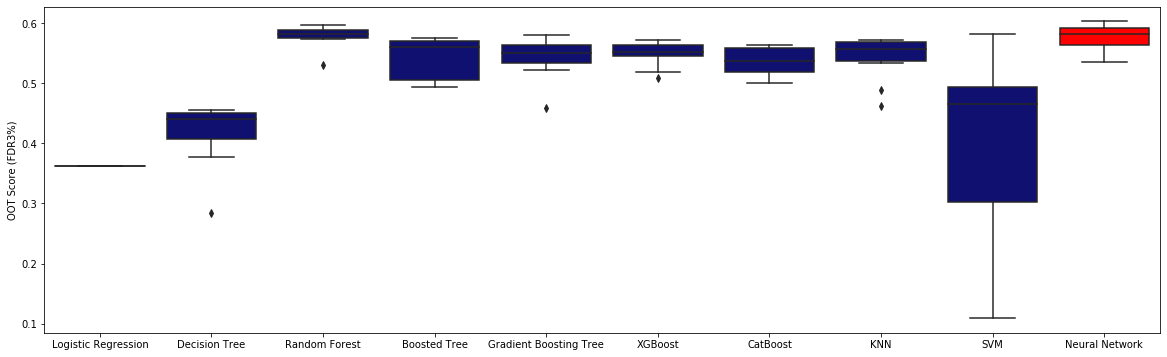

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
ax = sns.boxplot(x='Model',y='OOT', data=df, color='navy')

# Select which box you want to change    
mybox = ax.artists[9]

# Change the appearance of that box
mybox.set_facecolor('red')
# mybox.set_edgecolor('black')
# mybox.set_linewidth(3)
plt.xlabel('')
plt.ylabel('OOT Score (FDR3%)')
plt.show()


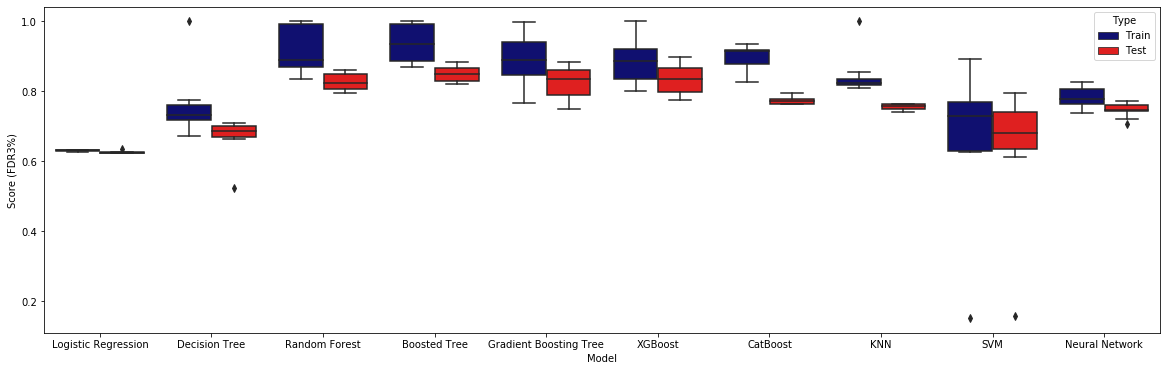

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
# ax = sns.boxplot(x='Model',y='OOT', data=df, color='navy')
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r'])
# Select which box you want to change    
mybox = ax.artists[9]

# Change the appearance of that box
# mybox.set_facecolor('red')
# mybox.set_edgecolor('black')
# mybox.set_linewidth(3)
# plxlabelabel('')
plt.ylabel('Score (FDR3%)')
plt.show()
